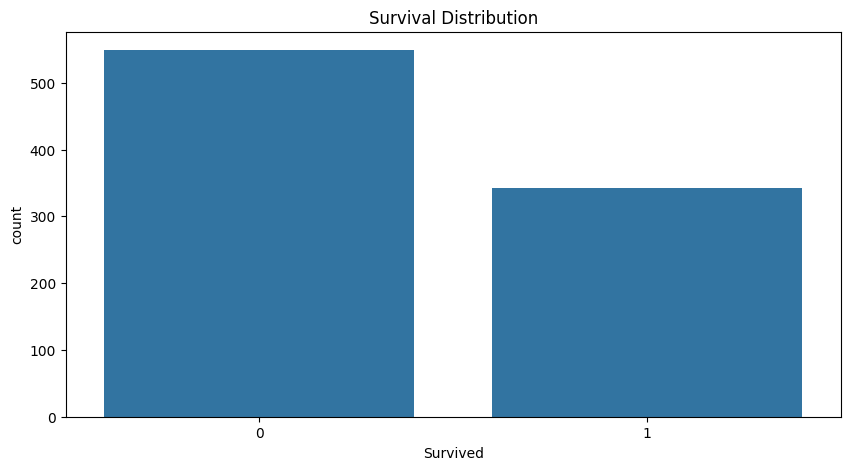

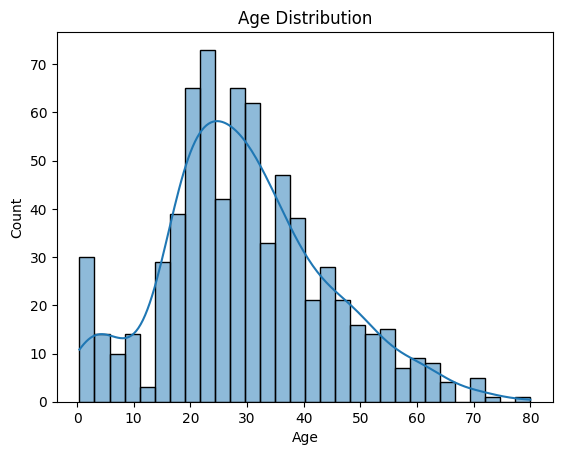

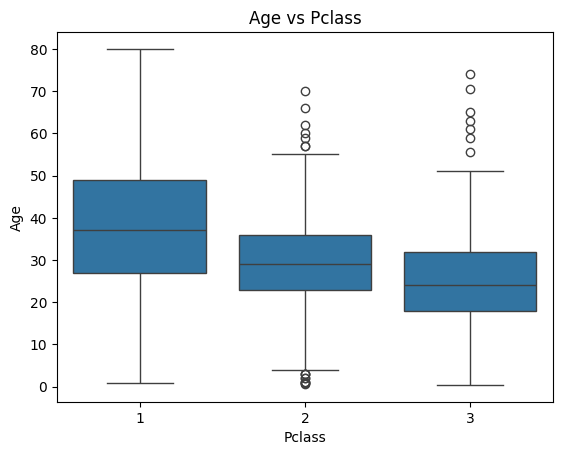

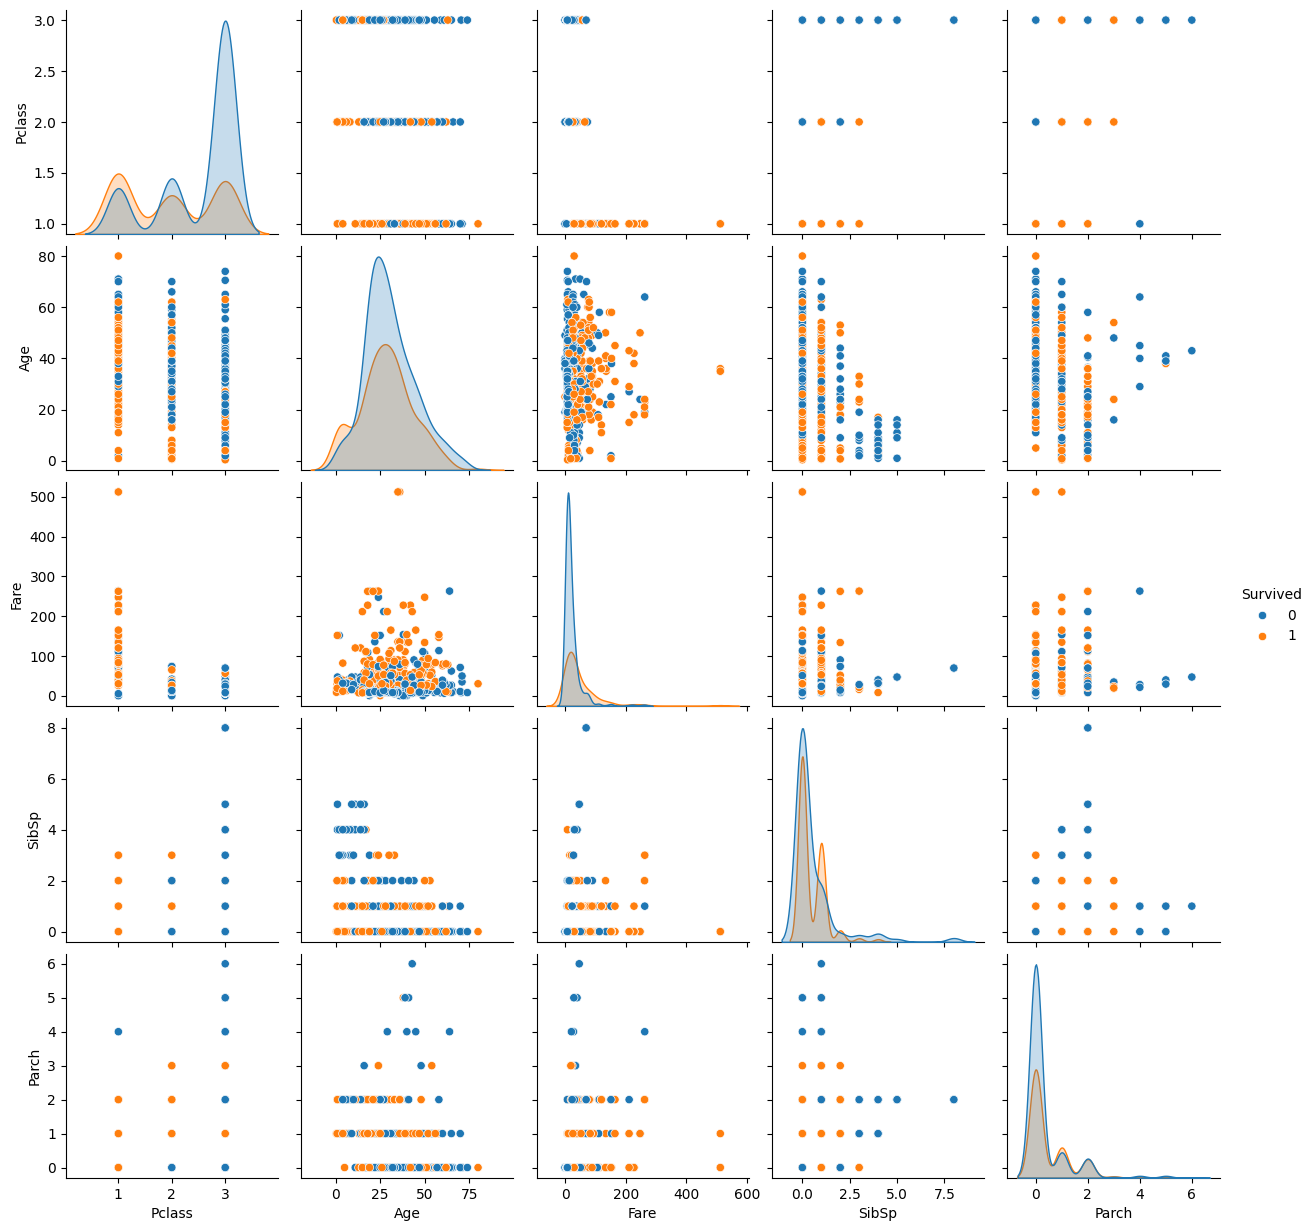

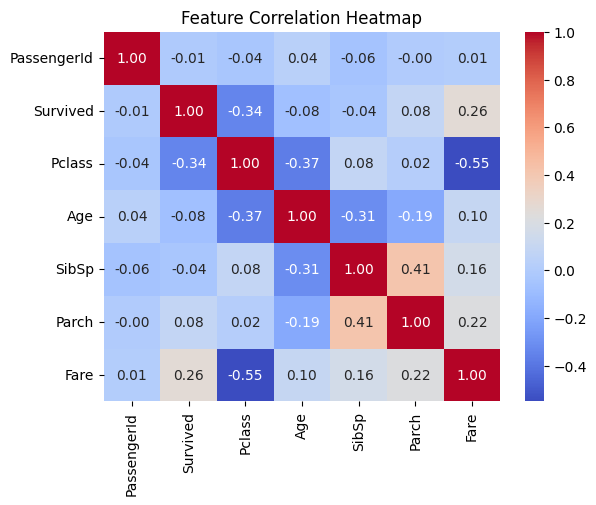

<ipython-input-9-0b01d9a36672>:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Pclass', y='Survived', data=train_df, ci=None)


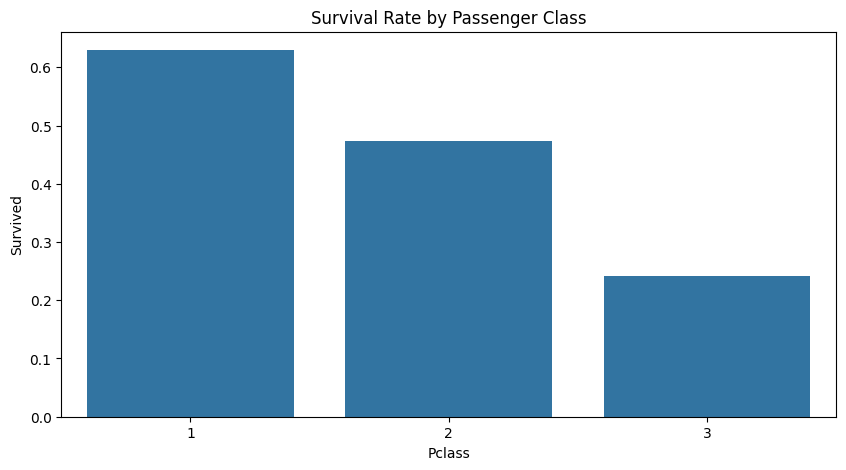

<ipython-input-9-0b01d9a36672>:49: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Sex', y='Survived', data=train_df, ci=None)


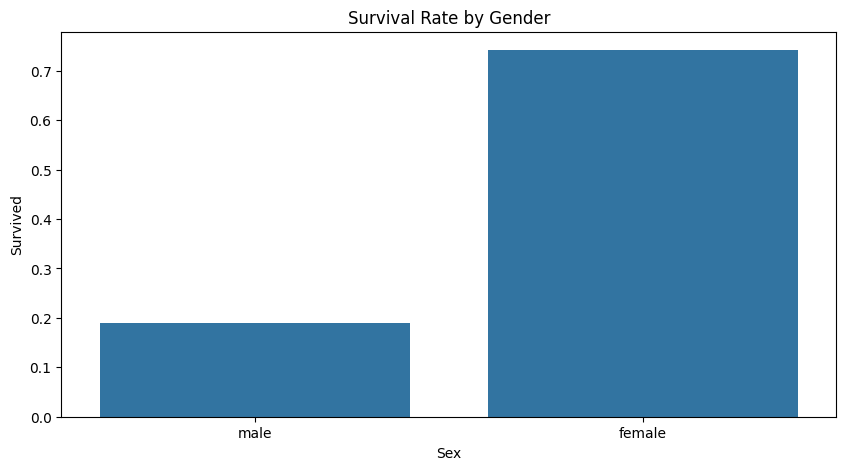

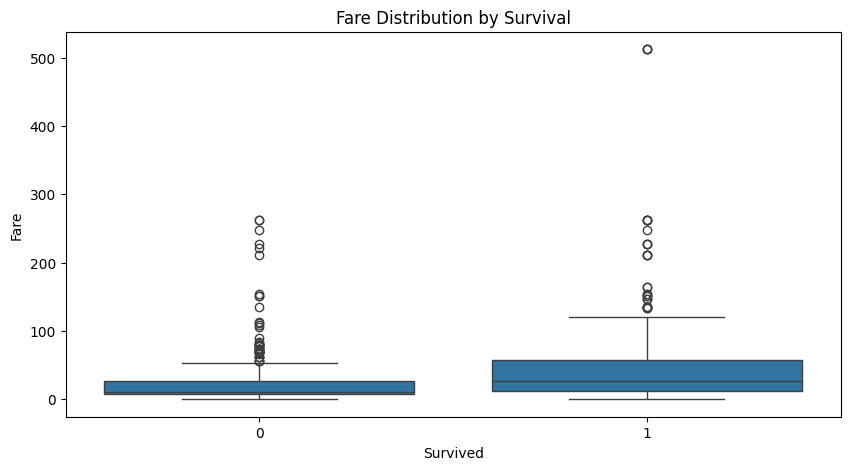

<ipython-input-9-0b01d9a36672>:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)


[LightGBM] [Info] Number of positive: 439, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 878, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:30:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


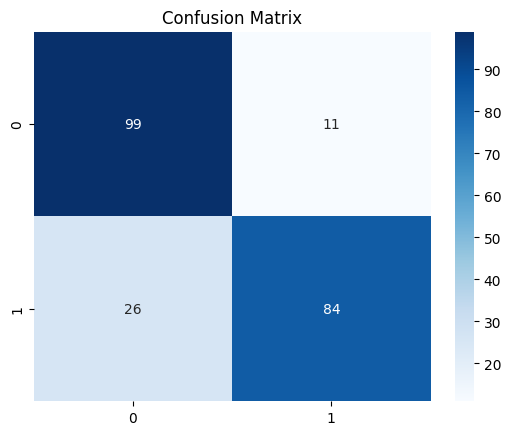

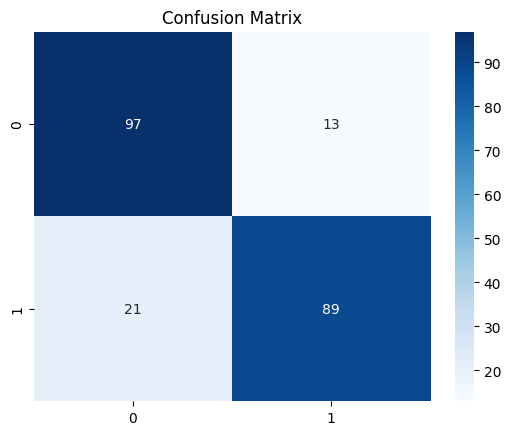

          Accuracy  Precision    Recall  F1-Score
LightGBM  0.831818   0.884211  0.763636  0.819512
XGBoost   0.845455   0.872549  0.809091  0.839623


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
import xgboost as xgb

# Load datasets
train_df = pd.read_csv("Titanic_train.csv")
test_df = pd.read_csv("Titanic_test.csv")

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 5))
sns.countplot(x='Survived', data=train_df)
plt.title("Survival Distribution")
plt.show()

sns.histplot(train_df['Age'].dropna(), bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

sns.boxplot(x='Pclass', y='Age', data=train_df)
plt.title("Age vs Pclass")
plt.show()

# Additional visualizations
sns.pairplot(train_df[['Survived', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch']], hue='Survived')
plt.show()

# Select only numeric features for correlation analysis
numeric_features = train_df.select_dtypes(include=np.number)

sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='Pclass', y='Survived', data=train_df, ci=None)
plt.title("Survival Rate by Passenger Class")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='Sex', y='Survived', data=train_df, ci=None)
plt.title("Survival Rate by Gender")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='Survived', y='Fare', data=train_df)
plt.title("Fare Distribution by Survival")
plt.show()

# Handling missing values
imputer = SimpleImputer(strategy='median')
train_df['Age'] = imputer.fit_transform(train_df[['Age']])
test_df['Age'] = imputer.transform(test_df[['Age']])
train_df['Fare'] = imputer.fit_transform(train_df[['Fare']])
test_df['Fare'] = imputer.transform(test_df[['Fare']])

# Fill missing embarked values with the most frequent one
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

# Drop Cabin due to high missing values
train_df.drop(columns=['Cabin', 'Name', 'Ticket'], inplace=True)
test_df.drop(columns=['Cabin', 'Name', 'Ticket'], inplace=True)

# Encode categorical variables
label_encoder = LabelEncoder()
train_df['Sex'] = label_encoder.fit_transform(train_df['Sex'])
test_df['Sex'] = label_encoder.transform(test_df['Sex'])
train_df['Embarked'] = label_encoder.fit_transform(train_df['Embarked'])
test_df['Embarked'] = label_encoder.transform(test_df['Embarked'])

# Define features and target
X = train_df.drop(columns=['Survived'])
y = train_df['Survived']
X_test = test_df.drop(columns=['PassengerId'])

# Data balancing techniques
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)
undersampler = RandomUnderSampler(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
X_under, y_under = undersampler.fit_resample(X, y)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

# Initialize models
lgb_model = lgb.LGBMClassifier()
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lgb_grid = GridSearchCV(lgb_model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
lgb_grid.fit(X_train, y_train)

xgb_grid = GridSearchCV(xgb_model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# Best models
best_lgb = lgb_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_

# Model evaluation
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    return {
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1-Score': f1_score(y_val, y_pred)
    }

lgb_results = evaluate_model(best_lgb, X_val, y_val)
xgb_results = evaluate_model(best_xgb, X_val, y_val)

# Compare results
results_df = pd.DataFrame([lgb_results, xgb_results], index=['LightGBM', 'XGBoost'])
print(results_df)

# Align the columns of the training and test sets
# Get missing columns in X_test compared to X_train
missing_cols = set(X_train.columns) - set(X_test.columns)

# Add missing columns to X_test with default value 0
for col in missing_cols:
    X_test[col] = 0

# Ensure the order of columns is the same as in X_train
X_test = X_test[X_train.columns]

# Predictions on test data
test_predictions_lgb = best_lgb.predict(X_test)
test_predictions_xgb = best_xgb.predict(X_test)

# Save predictions
submission_lgb = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': test_predictions_lgb})
submission_xgb = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': test_predictions_xgb})
submission_lgb.to_csv('submission_lgb.csv', index=False)
submission_xgb.to_csv('submission_xgb.csv', index=False)
